# Indoor Semantic Image Segmentation

**Notebook created in PyTorch by [ Xavier Riera, Albert Mestre, José Javier Gómez] for the [UPC School](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgraduate-course-artificial-intelligence-deep-learning/) (2020).**



Inicialization

In [ ]:
#Connect to drive
from google.colab import drive
!pipenv --clear
drive.mount('/content/drive/')

directory = 'drive/My Drive/Compartida con Albert/'
mypythondirectory = directory + 'Google Colabs/Scripts/'

import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as nIOU
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from skimage import io
from collections import defaultdict
from tqdm.notebook import tqdm as tqdm
from PIL import Image
import sys
sys.path.append(mypythondirectory)
import utils
import metrics
import models


seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Convert_Label13_to_RGB = {
    0: np.array([0, 0, 1]),
    1: np.array([0.9137, 0.3490, 0.1882]),
    2: np.array([0, 0.8549, 0]),
    3: np.array([0.5843, 0, 0.9412]),
    4: np.array([0.8706, 0.9451, 0.0941]),
    5: np.array([1.0000, 0.8078, 0.8078]),
    6: np.array([0, 0.8784, 0.8980]),
    7: np.array([0.4157, 0.5333, 0.8000]),
    8: np.array([0.4588, 0.1137, 0.1608]),
    9: np.array([0.9412, 0.1373, 0.9216]),
    10: np.array([0, 0.6549, 0.6118]),
    11: np.array([0.9765, 0.5451, 0]),
    12: np.array([0.8824, 0.8980, 0.7608]),
    255: np.array([0, 0, 0]),
}

def array_colors_13(prediction, dictionary = Convert_Label13_to_RGB) :
  colors = np.array([])
  for x in prediction.numpy() :
    item = np.array([])
    for y in x:
        c = dictionary[y]
        item = c if (item.size==0) else np.vstack((item, c))
    colors =  np.expand_dims(item, axis=0) if (colors.size==0) else np.vstack((colors, np.expand_dims(item, axis=0)))
  return colors

#variable to relate identifier-mean of clases
class_name_13 = ['bed', 'books', 'ceiling', 'chair', 'floor', 'furniture', 'objects', 'picture', 'sofa', 'table', 'tv', 'wall', 'window']

#Variable to define colors of classes
color_class_13  = ['#0000FF', '#E95930', '#00DA00', '#9500F0', '#DEF118', '#FFCECE', '#00E0E5', '#6A88CC', '#751D29', '#F023EB', '#00A79C', '#F98B00', '#E1E5C2']

class IndoorDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform = None, transform_img = None):
    self.dataset = pd.read_csv(root_dir + csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.transform_img = transform_img

  def __len__(self):
      return len(self.dataset)

  def __getitem__(self,index):


    RGBImage = io.imread(self.root_dir + self.dataset.iloc[index, 0])                             
    labelsImage = io.imread(self.root_dir + self.dataset.iloc[index, 1])                      

    if self.transform is not None:
      RGBImage, labelsImage = self.transform((RGBImage, labelsImage))
    if self.transform_img is not None:
      RGBImage = self.transform_img(RGBImage)
    return RGBImage , labelsImage

class ToPILImage(object):
    def __call__(self, sample):

        image, target = sample

        #toPILImage
        image = Image.fromarray(image)
        target = Image.fromarray(target)

        return (image, target)

class ResizeAndCenterCrop(object):
    def __init__(self, size=300):
        self.size = size
        self.transforms=transforms.Compose([transforms.CenterCrop(256)])

    def __call__(self, sample):

        image, target = sample

        #Resize image
        image = transforms.functional.resize(image, self.size)
        target = transforms.functional.resize(target, self.size, interpolation=Image.NEAREST)

        #Centercrop
        image = self.transforms(image)
        target = self.transforms(target)

        return (image, target)

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):

        image, target = sample

        #Convert to Tensor
        image = transforms.functional.to_tensor(np.array(image))
        target = torch.as_tensor(np.array(target), dtype=torch.int64)

        return (image, target)

#test
transformTest = transforms.Compose([
        ToPILImage(),
        ResizeAndCenterCrop(300),
        ToTensor(),
    ])

transformRGB = transforms.Compose([                                                           
      transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

hparams = {

    #BATCH_SIZE 
    'batch_size': 16, #32,
    
    #DEVICE
    'device':  torch.device("cuda" if torch.cuda.is_available() else "cpu"),

    #Define codification for not classified pixels in a label
    'NOT_CLASSIFIED_VALUE': 255,

}



#PATH_IMAGES
PATH_IMG = 'drive/My Drive/Compartida con Albert/Images/'

fparams = {
    
    #Directory definition
    'imagePath': PATH_IMG,

    'CSVTest': 'test.csv',

    #PATTERNS
    'train': 'train',
    'test': 'test',
    'validation': 'validation',
    'label': 'label',
}



def test(test_loader, network, criterion):
    # Dectivate the train=True flag inside the model
    network.eval()
    device = hparams['device']

    valLoss = utils.AverageMeter()

    iou_epoch = defaultdict(list)
    acc_epoch = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            data, target = data.to(device), target.to(device)
            output = network(data)
            
            val_loss = criterion(output, target).item() # sum up batch loss
            prediction = output.argmax(dim=1).detach().cpu()
            target = target.detach().cpu()


            #Add 255 labels in place where are not labeled
            prediction = utils.add255Label(target, prediction)

            #metrics
            iou = metrics.calculate_iou(prediction,target,hparams['NOT_CLASSIFIED_VALUE'])
            for (key, val) in iou.items(): 
              iou_epoch[key].append(val) 

            acc = metrics.accuracy(prediction,target, hparams['NOT_CLASSIFIED_VALUE'])
            acc_epoch.append(acc)


            #Retocar esto para quitarlo y ponerlo como ha sugerido Albert
            if batch_idx == 0:
              plt.title('Example ground through')
              plt.imshow(array_colors_13(target[0]))
              plt.show()
              plt.title('Example prediction')
              plt.imshow(array_colors_13(prediction[0]))
              plt.show()

            valLoss.update(val_loss)
          
    losses = valLoss.avg

    #print(losses)
    #writer_test.add_scalar('Loss', losses, epoch)
    #writer_test.add_image('Test Image', utils.array_colors_13(img_aux.transpose(1,0)).transpose(2,1,0) ,epoch)


    return iou_epoch, acc_epoch



def load_checkpoint(model_path, filename='model_best.pth.tar'):
  filename = model_path + filename
  
  checkpoint = torch.load(filename)
  return checkpoint

def IOUTable(test_metric, class_name_13, color_class_13):
  values_test = np.zeros(13)
  for (key,value) in test_metric.items():
    values_test[key] = np.round(100*np.array(value).mean(),2)

  A = [values_test]


  tableFigure = plt.figure(figsize=(14,2))
  table = plt.table(cellText=A,
                    colLabels = class_name_13,
                    colColours = color_class_13,
                    rowLabels = ['IOU'],
                    loc='center')
  ax = plt.gca()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  table.set_fontsize(14)
  plt.box(on=None)
  plt.show()
  return None

/bin/bash: pipenv: command not found
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


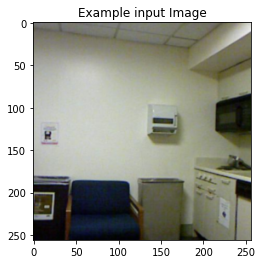

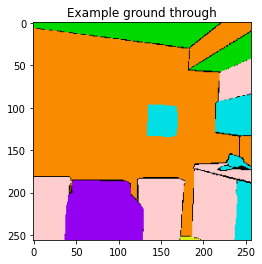

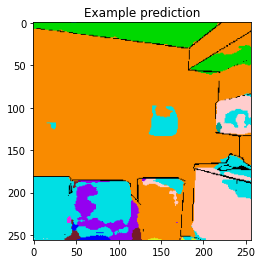

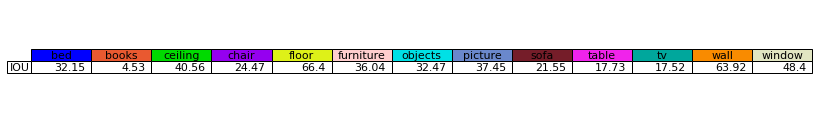

Mean IOU: 34.09%
Pixel Accuracy: 62.76%


In [ ]:
modelPath = 'drive/My Drive/Compartida con Albert/Results/image.segmentation.2020/HorizontalFlip_Corregido_v2/'
checkpoint = load_checkpoint(modelPath)

testData_aux = IndoorDataset(fparams['CSVTest'], fparams['imagePath'], transform = transformTest, transform_img = None)
testLoader_aux = DataLoader(dataset=testData_aux, batch_size=hparams['batch_size'], shuffle=False, num_workers=2)

for batch_idx, (data, target) in enumerate(testLoader_aux):
  plt.title('Example input Image')
  plt.imshow(data[0].cpu().transpose(0,2).transpose(1,0))
  plt.show()
  break


model = models.Unet()
model.load_state_dict(checkpoint['weights'])
model = model.to(hparams['device'])




testData = IndoorDataset(fparams['CSVTest'], fparams['imagePath'], transform = transformTest, transform_img = transformRGB)
testLoader = DataLoader(dataset=testData, batch_size=hparams['batch_size'], shuffle=False, num_workers=2)

criterion = torch.nn.CrossEntropyLoss(ignore_index = hparams['NOT_CLASSIFIED_VALUE'])  

IOU, Accuracy = test(test_loader=testLoader,network=model,criterion=criterion)





IOUTable(IOU, class_name_13, color_class_13)


IOUAverage = metrics.average_complexdict(IOU)
ACCAverage = metrics.average(Accuracy)

print('Mean IOU: ' + str(round(IOUAverage*100,2)) +'%')
print('Pixel Accuracy: ' + str(round(ACCAverage*100,2)) +'%')
